# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# this line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


# COVID-19 Data preprocessing

## we will use the data regarding the diagnosis of covid 19 gathered by the Israeli Ministry of Health: https://data.gov.il/dataset/covid-19

In [2]:
dataset = pd.read_csv("data/corona_tests.csv")
dataset

/home/nirlalum/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,age_60_and_above,gender,corona_result
0,2020-04-30,0,0,0,0,0,Other,None,female,negative
1,2020-04-30,1,0,0,0,0,Other,None,female,negative
2,2020-04-30,0,1,0,0,0,Other,None,male,negative
3,2020-04-30,1,0,0,0,0,Other,None,female,negative
4,2020-04-30,1,0,0,0,0,Other,None,male,negative
...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,Other,None,None,negative
278844,2020-03-11,0,0,0,0,0,Other,None,None,negative
278845,2020-03-11,0,0,0,0,0,Contact with confirmed,None,None,positive
278846,2020-03-11,0,0,0,0,0,Other,None,None,other


## EDA

In [3]:
dataset.head()


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,age_60_and_above,gender,corona_result
0,2020-04-30,0,0,0,0,0,Other,None,female,negative
1,2020-04-30,1,0,0,0,0,Other,None,female,negative
2,2020-04-30,0,1,0,0,0,Other,None,male,negative
3,2020-04-30,1,0,0,0,0,Other,None,female,negative
4,2020-04-30,1,0,0,0,0,Other,None,male,negative


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   test_date            278848 non-null  object
 1   cough                278848 non-null  object
 2   fever                278848 non-null  object
 3   sore_throat          278848 non-null  object
 4   shortness_of_breath  278848 non-null  object
 5   head_ache            278848 non-null  object
 6   test_indication      278848 non-null  object
 7   age_60_and_above     278848 non-null  object
 8   gender               278848 non-null  object
 9   corona_result        278848 non-null  object
dtypes: object(10)
memory usage: 21.3+ MB


In [5]:
# check for null values
dataset.isnull().sum()

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
test_indication        0
age_60_and_above       0
gender                 0
corona_result          0
dtype: int64

In [6]:
# this function checks the values count and type of all the columns of a dataframe
def check_values_count(data): 
    for column in data:
        if column == 'test_date':
            continue
        count = data[column].value_counts()
        print(f"the different values for {column}:\n {count} \n")

check_values_count(dataset)






the different values for cough:
 0       121649
0       114719
1        25875
1        16353
None       252
Name: cough, dtype: int64 

the different values for fever:
 0       133942
0       122902
1        13582
1         8170
None       252
Name: fever, dtype: int64 

the different values for sore_throat:
 0       260664
0        16257
1         1480
1          446
None         1
Name: sore_throat, dtype: int64 

the different values for shortness_of_breath:
 0       261079
0        16191
1         1065
1          512
None         1
Name: shortness_of_breath, dtype: int64 

the different values for head_ache:
 0       260079
0        16354
1         2065
1          349
None         1
Name: head_ache, dtype: int64 

the different values for test_indication:
 Other                     242741
Abroad                     25468
Contact with confirmed     10639
Name: test_indication, dtype: int64 

the different values for age_60_and_above:
 None    127320
No      125703
Yes      25825
Nam

### Conclusion: As we can see there are no null values but there are None values. we will deal with that later.
### Now we will check distributions of the data


### First we will check distribution of the diagnosis:

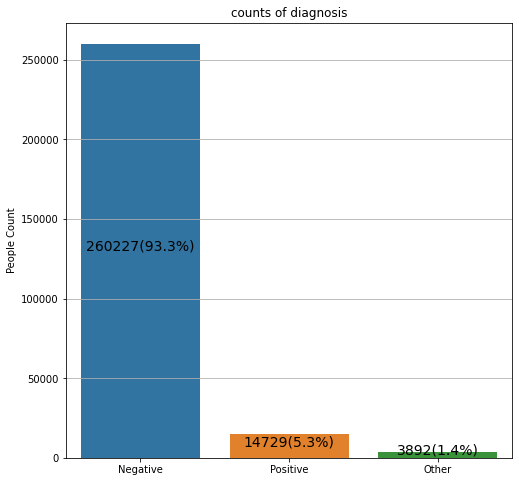

In [7]:
figure, diagnosis_bar = plt.subplots()
sns.barplot(x = dataset['corona_result'].value_counts().index, y = dataset['corona_result'].value_counts(), ax = diagnosis_bar)
diagnosis_bar.set_xticklabels(['Negative', 'Positive', 'Other'])
diagnosis_bar.set_ylabel('People Count')
diagnosis_bar.set_title('counts of diagnosis')

for patch in diagnosis_bar.patches:
    x_label = patch.get_x() + patch.get_width()/2
    y_label = patch.get_y() + patch.get_height()/2
    diagnosis_bar.text(x_label, y_label, str(int(patch.get_height())) + '(' +  '{:.1%}'.format(patch.get_height()/len(dataset['corona_result'])) + ')',
    horizontalalignment='center', verticalalignment='baseline', fontsize = 14)


### We can see that the data is imbalanced.
### Now we check the distributions of the different features and check how they influence the diagnosis (while we ignore None values, we will check the
### distributions again after data imputation).


In [12]:
# this function maps values for given dataset, column name and dictionary
# dict_costum is a boolean: True - dict is given from user else default dict 
def map_columns(data, column, dict_costum = False , map_dict = None):
    if dict_costum:
        data[column] = data[column].map(map_dict)
    else:
        dict_def = {0 : 'no' + ' ' + column, 1 : column}
        data[column] = data[column].map(dict_def)

data_plot_count = dataset.copy(deep=True)
columns_list = ['test_date' ,'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'test_indication', 'age_60_and_above', 'gender','corona_result']


for column in columns_list[1:6]: # for this columns there are a neglected amoout of Nones so we can just clean it
    indexNames = data_plot_count[data_plot_count[column]=='None'].index
    data_plot_count.drop(indexNames, inplace=True)


# cast the data to int
for column in columns_list[1:6]:
    data_plot_count[column] = data_plot_count[column].astype('str').astype('int')


# mapping the data from numbers to labels
for column in columns_list[1:6]:
    map_columns(data_plot_count, column)

check_values_count(data_plot_count)

"""
# plot histograms of the different features
fig, axs = plt.subplots(2, 4, figsize = (22, 14.0))
i, j = (0, 0)
for column in tqdm(dataset.columns):
    if column == 'test_date' or column == 'corona_result':
        continue
    
    ax = axs[i,j]
    sns.countplot(x = column, data=data_plot_count, ax = ax)
    
    if j == 3:
        i = i + 1
        j = 0
        continue
    
    j = j + 1

fig.tight_layout()
"""


the different values for cough:
 no cough    236368
cough        42226
Name: cough, dtype: int64 

the different values for fever:
 no fever    256843
fever        21751
Name: fever, dtype: int64 

the different values for sore_throat:
 no sore_throat    276672
sore_throat         1922
Name: sore_throat, dtype: int64 

the different values for shortness_of_breath:
 no shortness_of_breath    277020
shortness_of_breath         1574
Name: shortness_of_breath, dtype: int64 

the different values for head_ache:
 no head_ache    276186
head_ache         2408
Name: head_ache, dtype: int64 

the different values for test_indication:
 Other                     242504
Abroad                     25462
Contact with confirmed     10628
Name: test_indication, dtype: int64 

the different values for age_60_and_above:
 None    127315
No      125504
Yes      25775
Name: age_60_and_above, dtype: int64 

the different values for gender:
 female    130030
male      129012
None       19552
Name: gender, dt

"\n# plot histograms of the different features\nfig, axs = plt.subplots(2, 4, figsize = (22, 14.0))\ni, j = (0, 0)\nfor column in tqdm(dataset.columns):\n    if column == 'test_date' or column == 'corona_result':\n        continue\n    \n    ax = axs[i,j]\n    sns.countplot(x = column, data=data_plot_count, ax = ax)\n    \n    if j == 3:\n        i = i + 1\n        j = 0\n        continue\n    \n    j = j + 1\n\nfig.tight_layout()\n"

### The distributions displayed here describe Pr(pisitive|some feature):

the different values for cough:
 no cough    113009
cough        25163
Name: cough, dtype: int64 

the different values for fever:
 no fever    125320
fever        12852
Name: fever, dtype: int64 

the different values for sore_throat:
 no sore_throat    136676
sore_throat         1496
Name: sore_throat, dtype: int64 

the different values for shortness_of_breath:
 no shortness_of_breath    137090
shortness_of_breath         1082
Name: shortness_of_breath, dtype: int64 

the different values for head_ache:
 no head_ache    136073
head_ache         2099
Name: head_ache, dtype: int64 

the different values for test_indication:
 Other                     115951
Abroad                     14711
Contact with confirmed      7510
Name: test_indication, dtype: int64 

the different values for age_60_and_above:
 No     114092
Yes     24080
Name: age_60_and_above, dtype: int64 

the different values for gender:
 male      70101
female    68071
Name: gender, dtype: int64 

the different values fo

100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


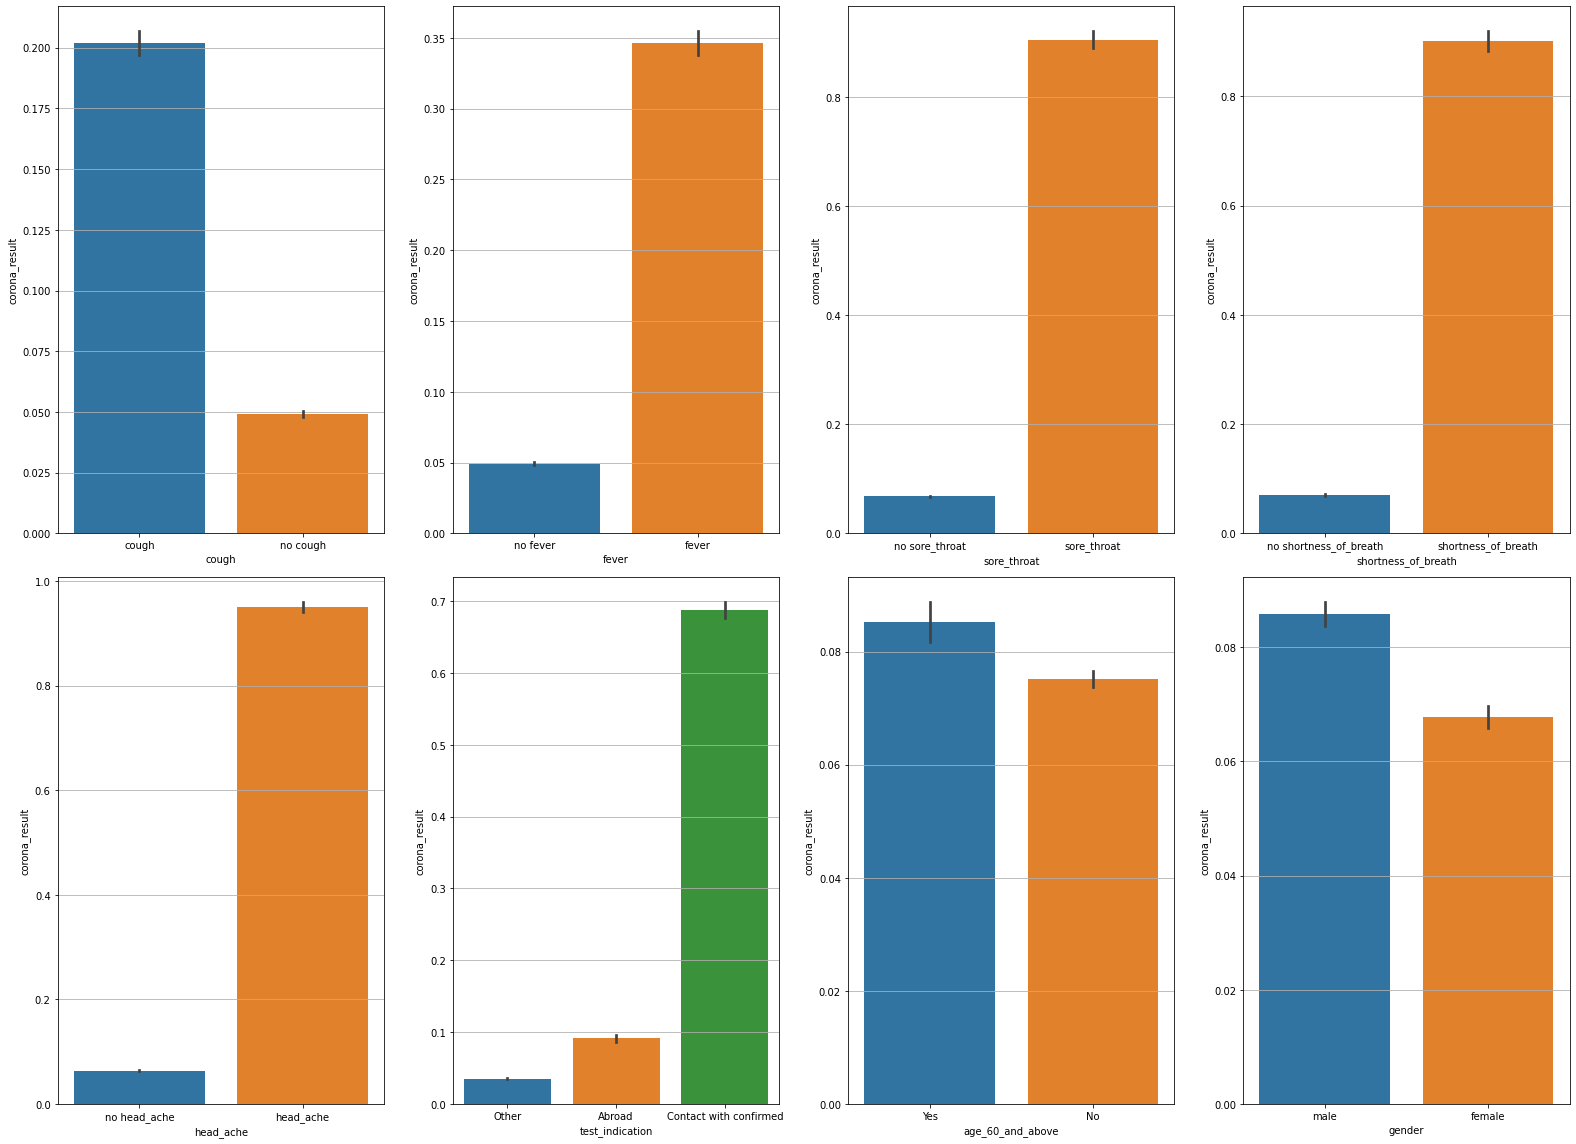

In [14]:
# ignore rows with None values (just for now - later we will do imputing)
data_plot = data_plot_count.copy(deep=True)
for column in columns_list[6:]:
    indexNames = data_plot[data_plot[column]=='None'].index
    data_plot.drop(indexNames, inplace=True)

check_values_count(data_plot) # check if the data is cleaned

# mapping the corona from labels to int
corona_result_dict = {'positive' : 1, 'negative' : 0, 'other' : 0} # should other be 0 or 1 or maybe deleted?
map_columns(data_plot, 'corona_result', dict_costum = True, map_dict = corona_result_dict)

#check_values_count(data_plot) # check if the data is mapped


# plot histograms of the different features
fig, axs = plt.subplots(2, 4, figsize = (22.0, 16.0))
i, j = (0, 0)
for column in tqdm(dataset.columns):
    if column == 'test_date' or column == 'corona_result':
        continue
    
    ax = axs[i,j]
    sns.barplot(x = column, y = 'corona_result', data=data_plot, ax = ax)
    
    if j == 3:
        i = i + 1
        j = 0
        continue
    
    j = j + 1

fig.tight_layout()



### We can see that there is a high correlation between beeing positive to having a sore throat, shortness of breath, head ache and if you were contacted with a confirm.
### We can also infer that there is a low correlation between beeing positive to age groups and gender. 
### About age_60_and_above: from my knowledge there is a high correlation between age group to developing severe condition but not to contagion. Also we saw ealier 
### that almost half of the column of age_60_and_above is filled with 'None' so we might delete this column.

In [99]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   test_date            278848 non-null  object
 1   cough                278848 non-null  object
 2   fever                278848 non-null  object
 3   sore_throat          278848 non-null  object
 4   shortness_of_breath  278848 non-null  object
 5   head_ache            278848 non-null  object
 6   test_indication      278848 non-null  object
 7   age_60_and_above     278848 non-null  object
 8   gender               278848 non-null  object
 9   corona_result        278848 non-null  object
dtypes: object(10)
memory usage: 21.3+ MB
